# Методы ДП для оценки функции ценности

Для демонстрации методов вычисления функции ценности состояний $v(s)$, рассмотрим задачу о сеточном мире из книги Р. Саттона и Э. Барто "Обучение с подкреплением", а также задачу о замёрзшем озере `FrozenLake` из библиотеки `gymnasium`.


### Пример 1

Средой является сеточный мир, который представляет собой клеточное поле размера 4 на 4 клетки. На поле есть две клетки с заключительными состояниями, которые отмечены серым цветом. Различные клетки соответствуют различным состояниям среды. Cостояния будем нумеровать индексами от 0 до 15. Незаключительными являются состояния из множества $\{1, 2, ..., 14\}$. 

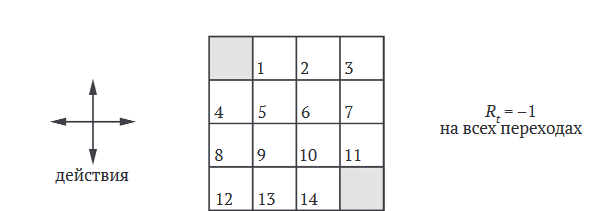

В каждой клетке возможно 4 действия - это перемещения по полю в 4 направлениях. Действия пронумерованы от 0 до 3:

    0: влево
    1: вниз
    2: вправо
    3: вверх 
    
Эти действия детерминированно переводят агента в соседнюю ячейку в соответствующем направлении. При этом:

* вознаграждение при любом переходе из незаключительных состояний равно $–1$; 
* в заключительных состояниях любое действие ведёт в него же, вознаграждение за любое действие равно $0$ и взаимодействие прекращается;
* действия, которые могли бы вывести агента за пределы сетки, оставляют его на месте с вознаграждением $–1$. 


Ключевым элементом дискретных сред, имеющих полное описание динамики среды, является набор данных `env.P`. Программно в языке Python этот набор данных будем представлять словарём словарей. У внешнего словаря ключами являются состояния $s$, а значениями `env.P[s]` будут словари, в которых ключи - это действия $a$, значения внутреннего словаря `env.P[s][a]`, хранят список, каждый элемент которого представляет собой кортеж (или tuple) из 4-х значений вида

$(p(s',r|s,a), s', r, terminated),$

то есть вероятность перехода в состояние $s'$ с вознаграждением $r$, состояние $s'$, вознаграждение $r$ и флаг $terminated$ о том, является ли состояние заключительным.

Программно эта среда реализована в отдельном файле `custom\env\gridworld.py`

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
# подгрузка среды
from custom.env.gridworld import GridWorld4by4

Создадим экземпляр среды в переменной `env`. Для инициализации среды можно использовать метод `env.reset()`

In [12]:
env = GridWorld4by4()
st, _ = env.reset()
print(st)

11


In [13]:
# проверка работы на действиях влево во всех состояниях
for state in range(1,16):
    
    env.state = state
    new_state, _, _, _, _ = env.step(0)
    print(new_state)

0
1
2
4
4
5
6
8
8
9
10
12
12
13
15


Можно также посмотреть информацию из набора данных `env.P` о динамике среды.

In [7]:
env.P[3]

{0: [(1.0, 2, -1, False)],
 1: [(1.0, 7, -1, False)],
 2: [(1.0, 3, -1, False)],
 3: [(1.0, 3, -1, False)]}

Пусть агент действует по некоторой стратегии $\pi$. В каждом из состояний возможно одно из 4-х действий. Будем обозначать действия влево, вниз, вправо, вверх за  $a_1,a_2,a_3,a_4$, соответственно. Значит, для каждого состояния $s$ надо задать список из четырёх чисел 
$$[\pi(a_1|s),\pi(a_2|s),\pi(a_3|s),\pi(a_4|s)],$$
означающих вероятность выбора того или иного действия в состоянии $s$.

Программно стратегию будем задавать в виде массива чисел `policy` размера 16 на 4.

Вычисление функции ценности реализуем в виде двух отдельных функций: **по итеративному методу** и **точному методу**. 

Итеративный метод реализуем с **in-place** вычислениями.

#### Итеративный метод

Итеративная формула обновления оценки ценности состояния $s$ имеет вид

$V(s) := \sum\limits_{a\in {\mathcal A}} \pi(a|s)  
\sum\limits_{s'\in {\mathcal S}}
\sum\limits_{r\in {\mathcal R}}
p(s',r|s,a) (r + \gamma V(s')), \quad s\in {\mathcal S},$

где $V(s)$ оценка ценности состояния $s$, $p(s',r|s,a)$ вероятность перехода из состояния $s$ при действии $a$ в состояние $s'$ с вознаграждением $r$. 

Критерий остановки сформируем как в псевдокоде в лекции.

In [17]:
def PolicyEvaluation(env, policy, gamma, theta=1e-5):
    nS = env.observation_space.n # количество различных состояний    
    V = np.zeros(nS)             # начальная оценка ценностей состояний
    error = []       # массив для хранения ошибки
    while True:
        delta = 0
        # Вычисление новых оценок для всех состояний
        for state in range(nS):         
            v_s_old = V[state] # запоминаем значение v(s), для его сравнения с обновлённым значением v(s)
            v_s = 0 # для вычисления обновлённого значения v(s)        
            act_probs = policy[state]
            for act, act_prob in enumerate(act_probs):
                for next_sr in env.P[state][act]:
                    trans_prob, new_state, reward, _ = next_sr
                    v_s += act_prob * trans_prob * (reward + gamma * V[new_state])
            V[state] = v_s
            # найдём разницу между старым и новым значением v(s)
            delta = np.max([delta, np.abs(V[state] - v_s_old)])
        # Критерий завершения итераций
        error.append(delta)
        if delta < theta:
            break
    return V, error

#### Точный метод

Надо сформировать матрицу $I-\gamma P$ и столбец $R$. Здесь $I$ единичная матрица, $P = \{P^{\pi}(s'|s)\}$ матрица вероятностей перехода из состояния $s$ в состояние $s'$:

$P^{\pi}(s'|s) = \sum\limits_{a\in {\mathcal A}} \pi(a|s)  
\sum\limits_{r\in {\mathcal R}} p(s',r|s,a) = \sum\limits_{a\in {\mathcal A}(s,s')} \pi(a|s)$,

где ${\mathcal A}(s,s')$ - это те действия, которые переведут состояние $s$ в $s'$ с ненулевой вероятностью (если оно пусто, то сумма равна 0).

Столбец $R = \{R^{\pi}(s)\}$ состоит из ожидаемых вознаграждений в состояниях $s \in {\mathcal S}$:

$R^{\pi}(s) = \sum\limits_{a\in {\mathcal A}} \pi(a|s) 
\sum\limits_{r\in {\mathcal R}} r \sum\limits_{s'\in {\mathcal S}}p(s',r|s,a)  = \sum\limits_{a\in {\mathcal A}(s,s')} \pi(a|s) r.$

### Задача: реализовать точный метод

In [19]:
def PolicyEvaluationExact(env, policy, gamma):
# нахождение точных значений функции ценности из решения СЛАУ
    ...
    ...
    ...
    
    return V

Предположим, что агент следует **равновероятной** случайной стратегии (все действия выбираются с одинаковой вероятностью). Вычислим функцию ценности состояний $v_\pi(s)$ при такой стратегии и при $\gamma = 0.9.$
Выведем также график убывания ошибки.

[[ 0.    -5.278 -7.128 -7.65 ]
 [-5.278 -6.606 -7.181 -7.128]
 [-7.128 -7.181 -6.606 -5.278]
 [-7.65  -7.128 -5.278  0.   ]]


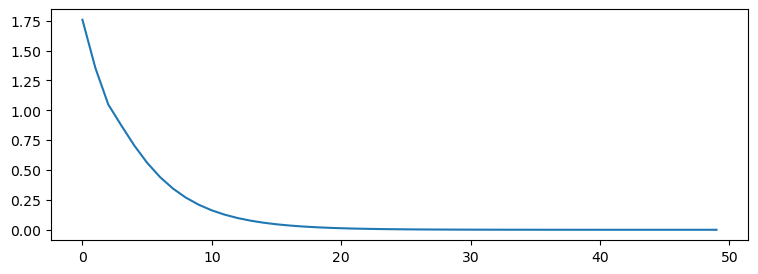

In [21]:
gamma = 0.9
policy = np.zeros((env.observation_space.n, env.action_space.n)) + 1/4

# итеративное вычисление функции ценности 
new_value, error = PolicyEvaluation(env, policy, gamma)
print(np.round(new_value,3).reshape(4,4))
plt.figure(figsize=(9,3))
plt.plot(error)

In [23]:
# точное вычисление функции ценности 
gamma = 0.9
np.round(PolicyEvaluationExact(env, policy, gamma),3).reshape(4,4)

array([[-0.   , -5.278, -7.128, -7.651],
       [-5.278, -6.606, -7.181, -7.128],
       [-7.128, -7.181, -6.606, -5.278],
       [-7.651, -7.128, -5.278,  0.   ]])

Поскольку задача эпизодическая, то можно положить $\gamma = 1$. Тогда ценности состояний будут означать среднее число шагов из этого состояния до заключительного состояния с обратным знаком. В силу выбранной системы вознаграждений, максимизация дохода предполагает как можно более быстрое движение в заключительные состояния из клеток сеточного мира.

In [25]:
gamma = 1.0
policy = np.zeros((env.observation_space.n, env.action_space.n)) + 1/4

# итеративное вычисление функции ценности 
new_value, _ = PolicyEvaluation(env, policy, gamma)
print(np.round(new_value).reshape(4,4))

[[  0. -14. -20. -22.]
 [-14. -18. -20. -20.]
 [-20. -20. -18. -14.]
 [-22. -20. -14.   0.]]


Для проверки можно рассмотреть значение во второй строке и первом столбце, равное -14. Запишем уравнение Беллмана для этого значения, слагаемые записаны по порядку действий: влево, вниз, вправо, вверх

$$
0.25(-1 + (-14)) + 0.25(-1 + (-20)) + 0.25(-1 + (-18)) + 0.25(-1 + 0) = -14
$$

### Сравнения разных способов организации вычислений

Сравним два варианта организации вычислений: с полным обновлением и обновлением in-place.

Для этого модифицируем метод PolicyEvaluation(), чтобы он выдавал число итераций для сходимости.

In [56]:
def PolicyEvaluation(env, policy, gamma, theta=1e-5):
    nS = env.observation_space.n # количество различных состояний    
    V = np.zeros(nS)             # начальная оценка ценностей состояний
    iteration = 0
    while True:
        delta = 0
        # Вычисление новых оценок для всех состояний
        for state in range(nS):         
            v_s_old = V[state] # запоминаем значение v(s), для его сравнения с обновлённым значением v(s)
            v_s = 0 # для вычисления обновлённого значения v(s)        
            act_probs = policy[state]
            for act, act_prob in enumerate(act_probs):
                for next_sr in env.P[state][act]:
                    trans_prob, new_state, reward, _ = next_sr
                    v_s += act_prob * trans_prob * (reward + gamma * V[new_state])
            V[state] = v_s
            # найдём разницу между старым и новым значением v(s)
            delta = np.max([delta, np.abs(V[state] - v_s_old)])
        iteration = iteration + 1
        # Критерий завершения итераций
        if delta < theta:
            break
        if iteration > 2000:
            print("Более 2000 итераций. Стоп.")
            return V
        # демонстрация динамики обучения
        if iteration == 1 or iteration == 2 or iteration == 5 or iteration == 10 or iteration == 50:
            print("Итерация: ", iteration)
            print(V.reshape(4,4)) 
    print("Число итераций: ", iteration)
    return V

In [58]:
def PolicyEvaluation_FullUpdate(env, policy, gamma, theta=1e-5):
    nS = env.observation_space.n # количество различных состояний    
    V = np.zeros(nS)             # начальная оценка ценностей состояний
    iteration = 0
    while True:
        delta = 0
        # Вычисление новых оценок для всех состояний
        old_V = V.copy() # создаём копию массива
        for state in range(nS):         
            v_s = 0 # для вычисления обновлённого значения v(s)        
            act_probs = policy[state]
            for act, act_prob in enumerate(act_probs):
                for next_sr in env.P[state][act]:
                    trans_prob, new_state, reward, _ = next_sr
                    v_s += act_prob * trans_prob * (reward + gamma * old_V[new_state])
            V[state] = v_s
            # найдём разницу между старым и новым значением v(s)
            delta = np.max([delta, np.abs(V[state] - old_V[state])])
        iteration = iteration + 1
        # Критерий завершения итераций
        if delta < theta:
            break
        if iteration > 2000:
            print("Более 2000 итераций. Стоп.")
            return V
        # демонстрация динамики обучения
        if iteration == 1 or iteration == 2 or iteration == 5 or iteration == 10 or iteration == 50:
            print("Итерация: ", iteration)
            print(V.reshape(4,4)) 
    print("Число итераций: ", iteration)
    return V

Проведём сравнений вычислений.

In [60]:
gamma = 1.0
policy = np.zeros((env.observation_space.n, env.action_space.n)) + 1/4

new_value = PolicyEvaluation(env, policy, gamma=1.0)
print(np.round(new_value).reshape(4,4))

Итерация:  1
[[ 0.        -1.        -1.25      -1.3125   ]
 [-1.        -1.5       -1.6875    -1.75     ]
 [-1.25      -1.6875    -1.84375   -1.8984375]
 [-1.3125    -1.75      -1.8984375  0.       ]]
Итерация:  2
[[ 0.         -1.9375     -2.546875   -2.73046875]
 [-1.9375     -2.8125     -3.23828125 -3.40429688]
 [-2.546875   -3.23828125 -3.56835938 -3.21777344]
 [-2.73046875 -3.40429688 -3.21777344  0.        ]]
Итерация:  5
[[ 0.         -4.49046326 -6.30054855 -6.91293049]
 [-4.49046326 -6.26144409 -7.22480297 -7.36922646]
 [-6.30054855 -7.22480297 -7.1876235  -5.9268235 ]
 [-6.91293049 -7.36922646 -5.9268235   0.        ]]
Итерация:  10
[[  0.          -7.82506756 -11.12181872 -12.22765503]
 [ -7.82506756 -10.42037166 -11.76933739 -11.86339862]
 [-11.12181872 -11.76933739 -11.0538181   -8.81387889]
 [-12.22765503 -11.86339862  -8.81387889   0.        ]]
Итерация:  50
[[  0.         -13.81370235 -19.73217221 -21.70520586]
 [-13.81370235 -17.77138835 -19.75178028 -19.75461852]
 [-

In [62]:
new_value = PolicyEvaluation_FullUpdate(env, policy, gamma=1.0)
print(np.round(new_value).reshape(4,4))

Итерация:  1
[[ 0. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1.  0.]]
Итерация:  2
[[ 0.   -1.75 -2.   -2.  ]
 [-1.75 -2.   -2.   -2.  ]
 [-2.   -2.   -2.   -1.75]
 [-2.   -2.   -1.75  0.  ]]
Итерация:  5
[[ 0.        -3.65625   -4.6953125 -4.90625  ]
 [-3.65625   -4.484375  -4.78125   -4.6953125]
 [-4.6953125 -4.78125   -4.484375  -3.65625  ]
 [-4.90625   -4.6953125 -3.65625    0.       ]]
Итерация:  10
[[ 0.         -6.13796997 -8.35235596 -8.96731567]
 [-6.13796997 -7.73739624 -8.42782593 -8.35235596]
 [-8.35235596 -8.42782593 -7.73739624 -6.13796997]
 [-8.96731567 -8.35235596 -6.13796997  0.        ]]
Итерация:  50
[[  0.         -13.11718187 -18.6918225  -20.53607201]
 [-13.11718187 -16.84757299 -18.70057333 -18.6918225 ]
 [-18.6918225  -18.70057333 -16.84757299 -13.11718187]
 [-20.53607201 -18.6918225  -13.11718187   0.        ]]
Число итераций:  215
[[  0. -14. -20. -22.]
 [-14. -18. -20. -20.]
 [-20. -20. -18. -14.]
 [-22. -20. -14.   0.]]


Как ясно из полученных результатов, при вычислениях in-place число итераций для сходимости требуется заметно меньше. 

### Итоговый код для метода оценки стратегии

Приведём итоговый код для оценки стратегии, вычисляющий функцию ценности состояний при фиксированной стратегии.

In [65]:
def PolicyEvaluation(env, policy, gamma, theta=1e-5):
    nS = env.observation_space.n # количество различных состояний    
    V = np.zeros(nS)             # начальная оценка ценностей состояний
    iteration = 0
    while True:
        delta = 0
        # Вычисление новых оценок для всех состояний
        for state in range(nS):         
            v_s_old = V[state] # запоминаем значение v(s), для его сравнения с обновлённым значением v(s)
            v_s = 0 # для вычисления обновлённого значения v(s)        
            act_probs = policy[state]
            for act, act_prob in enumerate(act_probs):
                for next_sr in env.P[state][act]:
                    trans_prob, new_state, reward, _ = next_sr
                    v_s += act_prob * trans_prob * (reward + gamma * V[new_state])
            V[state] = v_s
            # найдём разницу между старым и новым значением v(s)
            delta = np.max([delta, np.abs(V[state] - v_s_old)])
        iteration = iteration + 1
        # Критерий завершения итераций
        if delta < theta:
            break
        if iteration > 2000:
            print("Более 2000 итераций. Стоп.")
            return V
    print("Число итераций: ", iteration)
    return V

In [67]:
gamma = 1.0
policy = np.zeros((env.observation_space.n, env.action_space.n)) + 1/4


# итеративное вычисление функции ценности 
V = PolicyEvaluation(env, policy, gamma)

Число итераций:  141


In [69]:
print(np.round(V).reshape(4,4))

[[  0. -14. -20. -22.]
 [-14. -18. -20. -20.]
 [-20. -20. -18. -14.]
 [-22. -20. -14.   0.]]


### Пример 2

Рассмотрим задачу из библиотеки `gymnasium` о замерзшем озере "FrozenLake-v1". Средой является поле из 16 состояний, как в задаче выше, но разные клетки имеют разное значение. Вид поля:

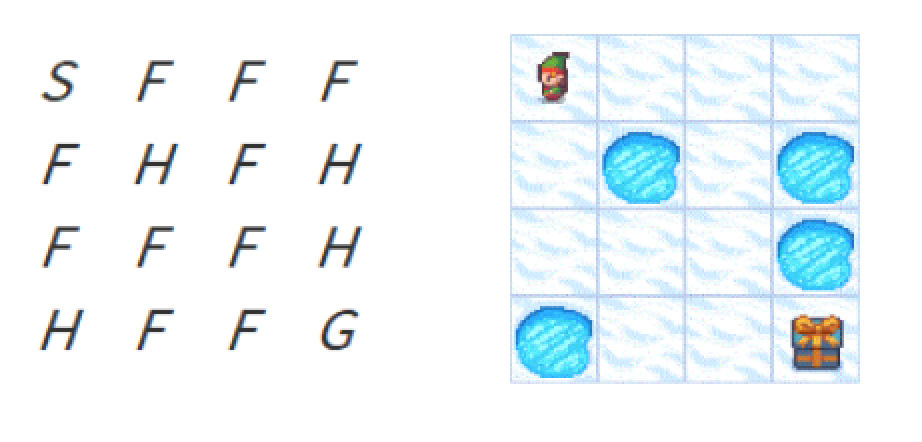

Здесь:

    S (start) начало
    F (frozen) участок со льдом, где можно идти
    H (hole) полынья, надо избегать
    G (goal) цель.
    
Действия - это перемещения по полю в 4 направления: 

    0: влево
    1: вниз
    2: вправо
    3: вверх
    
Из-за скольского льда есть вероятность перехода не в том направлении. Например, при действии "вниз" с вероятностью 1/3 агент переместится либо вниз, либо влево, либо вправо (причём если перемещение за край поля, то агент останется на месте). 

Цель: добраться из клетки S до клетки G. Вознаграждение за успешное завершение эпизода +1. За все прочие действия 0.

Эпизод завершается при успешном завершении, при попадании на клетку $H$, либо по истечении 100 временных шагов.

In [71]:
import gymnasium as gym
import numpy as np

#создание экземпляра среды, обёртка unwrapped для доступа к матрице переходов env.P
env = gym.make("FrozenLake-v1").unwrapped 
env.reset() # инициализация среды
# вывод динамики переходов
env.P

{0: {0: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  2: [(0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)],
  3: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 1: {0: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False)],
  2: [(0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  3: [(0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 2:

In [73]:
env.step(0)

(0, 0.0, False, False, {'prob': 0.3333333333333333})

Например, ниже выведены вероятности перехода из состояния 1 и действия 1:

In [75]:
env.P[1][1]

[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 5, 0.0, True),
 (0.3333333333333333, 2, 0.0, False)]

Продемонстрируем взаимодействие агента со средой (появляется в отдельном окошке, если `render_mode='human'`)

In [86]:
import time

env = gym.make("FrozenLake-v1", render_mode='human')
env.reset()

while True:
    time.sleep(.2)
    state, reward, terminated, truncated, _ = env.step(env.action_space.sample()) # выбрать действие случайно
    if terminated or truncated:
        break
    
env.close()

Для упрощённого способа демонстрации взаимодействия агента со средой можно использовать следующий код (для этого надо поставить параметр render_mode='ansi').

In [77]:
import time
from IPython.display import clear_output

env = gym.make("FrozenLake-v1", render_mode='ansi')
env.reset()
print(env.render())

while True:    
    state, reward, terminated, truncated, _ = env.step(env.action_space.sample()) # выбрать действие случайно
    
    time.sleep(.2)
    clear_output(wait=True)      
    print(env.render())
    
    if terminated or truncated:
        break
    
env.close()

  (Left)
SFFF
FHFH
FFFH
HFFG



Найдём функцию ценности состояний для стратегии с равновероятным выбором действий

In [79]:
env = gym.make("FrozenLake-v1", render_mode='ansi').unwrapped 
# стратегия равновероятного выбора
gamma = 1.0
# число состояний и действий
nS = env.observation_space.n
nA = env.action_space.n

policy = np.zeros([nS, nA]) + 1/4
V = PolicyEvaluation(env, policy, gamma)
print(V.reshape(4,4))

Число итераций:  31
[[0.013911   0.01161424 0.02094062 0.01046758]
 [0.01623478 0.         0.04074774 0.        ]
 [0.03479961 0.08816698 0.14205099 0.        ]
 [0.         0.17581855 0.4392897  0.        ]]


Проведём симуляцию на большом числе эпизодов и найдём число успешных завершений среды при случайной стратегии.

In [81]:
n_episodes = 10000
env = gym.make("FrozenLake-v1", render_mode='ansi')
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

def play(env, n_episodes):
    for episode in range(n_episodes):
        state, _ = env.reset()
        while True:
            # равновероятно выбираем действия
            action = env.action_space.sample()
            state, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break
            
play(env, n_episodes)
print("Число успешных завершений эпизода: ", sum(env.return_queue))

Число успешных завершений эпизода:  153.0
